# Imports and Functions

In [2]:
import pandas as pd
from time import time

import visuals as vs 

%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [3]:
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict, average='micro')
        _val_recall = recall_score(val_targ, val_predict, average='micro')
        _val_precision = precision_score(val_targ, val_predict, average='micro')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print(" — val_f1: {:.4f} — val_precision: {:.4f} — val_recall {:.4f}".format(_val_f1, _val_precision, _val_recall))
        return
    
metrics = Metrics()

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load Data

In [4]:
df_data = pd.read_csv('../data/data_feat.csv')
df_data.head()

,SUBJECT,AUTHOR,TEXT,TEXT_CLEAN,NUM_STOPWORDS,NUM_PUNCTUATIONS,NUM_WORDS_UPPER,NUM_CHARS,NUM_WORDS,AVG_WORD
0,ASSUNTOS VARIADOS,LUIZ FLAVIO SAPORI,19/03/2009\nFATO CORRIQUEIRO\nO fato mais impo...,19 03 2009 fato corriqueiro fato importante se...,67,29,5,1375,199,5.787129
1,ASSUNTOS VARIADOS,LUIZ FLAVIO SAPORI,06/07/2009\nPOLÍTICA DE ESTADO\nUm problema cr...,06 07 2009 politica estado problema cronico po...,75,29,11,1342,207,5.449275
2,ASSUNTOS VARIADOS,LUIZ FLAVIO SAPORI,12/07/2009\nTOQUE DE RECOLHER\nProcurado para ...,12 07 2009 toque recolher procurado suspender ...,95,46,11,1587,257,5.180392
3,ASSUNTOS VARIADOS,LUIZ FLAVIO SAPORI,23/03/2009\nCRISE SOCIOEDUCATIVA\nOcorreram du...,23 03 2009 crise socioeducativa ocorreram duas...,55,26,6,1141,167,5.761905
4,ASSUNTOS VARIADOS,LUIZ FLAVIO SAPORI,24/12/2008\nESTATÍSTICAS CRIMINAIS CONFIÁVEIS\...,24 12 2008 estatisticas criminais confiaveis b...,133,43,17,2309,366,5.246612


# Prep Data

In [5]:
df_data['SUBJECT'] = df_data['SUBJECT'].astype('category')
df_data['AUTHOR'] = df_data['AUTHOR'].astype('category')

In [6]:
#df_data['AUTHOR_CODE'] = df_data['AUTHOR'].astype('category').cat.codes

In [7]:
#df_data.head()

In [8]:
#classes = dict(enumerate(df_data['AUTHOR'].cat.categories))
#classes

# One Hot Encode Target

In [9]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(df_data['AUTHOR'])
encoded_Y = encoder.transform(df_data['AUTHOR'])
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

# Split Dataset

In [10]:
from sklearn.model_selection import train_test_split
sentences_train, sentences_test, y_train, y_test = train_test_split(df_data['TEXT_CLEAN'], dummy_y,
                                                    test_size=0.2, stratify=df_data['AUTHOR'], random_state=42)

In [11]:
print(f'train shape {sentences_train.shape}')
print(f'test shape {sentences_test.shape}')

train shape (2402,)
test shape (601,)


# BOW Texts

In [59]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train

<2402x62456 sparse matrix of type '<class 'numpy.int64'>'
	with 520605 stored elements in Compressed Sparse Row format>

# Keras Shallow NN

In [11]:
from keras.models import Sequential
from keras import layers

In [45]:
input_dim = X_train.shape[1]  # Number of features
input_dim

62456

In [13]:
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(100, activation='softmax'))

In [41]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['sparse_categorical_accuracy', 'accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                624570    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               1100      
Total params: 625,670
Trainable params: 625,670
Non-trainable params: 0
_________________________________________________________________


In [42]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10,
                    callbacks=[metrics])

Train on 2402 samples, validate on 601 samples
Epoch 1/10
2402/2402 [==============================] - 5s 2ms/step - loss: 1.2050e-07 - sparse_categorical_accuracy: 0.0100 - acc: 1.0000 - val_loss: 2.8985 - val_sparse_categorical_accuracy: 0.0017 - val_acc: 0.5641
 — val_f1: 0.5828 — val_precision: 0.6231 — val_recall 0.5474
Epoch 2/10
2402/2402 [==============================] - 4s 2ms/step - loss: 1.2057e-07 - sparse_categorical_accuracy: 0.0100 - acc: 1.0000 - val_loss: 2.8920 - val_sparse_categorical_accuracy: 0.0017 - val_acc: 0.5657
 — val_f1: 0.5841 — val_precision: 0.6238 — val_recall 0.5491
Epoch 3/10
2402/2402 [==============================] - 4s 2ms/step - loss: 1.2047e-07 - sparse_categorical_accuracy: 0.0100 - acc: 1.0000 - val_loss: 2.8953 - val_sparse_categorical_accuracy: 0.0017 - val_acc: 0.5657
 — val_f1: 0.5839 — val_precision: 0.6255 — val_recall 0.5474
Epoch 4/10
2402/2402 [==============================] - 4s 2ms/step - loss: 1.2045e-07 - sparse_categorical_accur

In [47]:
loss, sparse_categorical_accuracy, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, sparse_categorical_accuracy, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.5624


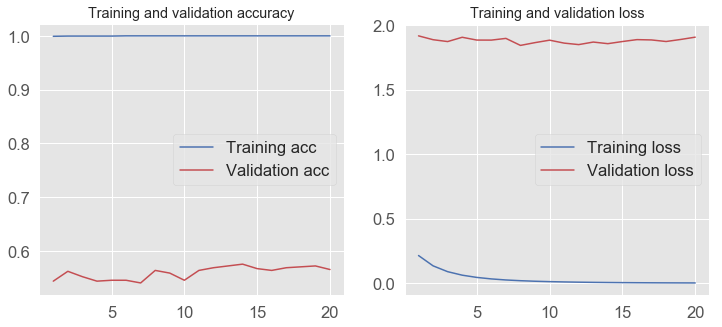

In [59]:
plot_history(history)

# Word Embeddings

## Tokenize

In [12]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[2])
print(X_train[2])

12 07 2009 toque recolher procurado suspender toque recolher jovens conselho nacional justica cnj concedeu ontem primeiro parecer favoravel medida restritiva resposta questionamento contra determinacao juiza nova andradina ms jacqueline machado agora menos 13 comarcas 7 estados adotaram medida caso mantida decisao julgamento merito cabera recurso somente supremo tribunal federal stf conselho nacional direitos crianca adolescente conanda chegou enviar cnj parecer afirma toque recolher fere dois artigos constituicao seis estatuto crianca adolescente eca trata direito ir vir texto afirmase toque recolher impoe situacoes vexatorias criancas carater perseguicao despeito debate juridico relevante refletirmos sobre oportunidade efetividade imposicao tal regra medida restricao circulacao partir determinado horario vias publicas criancas adolescentes contribui ordem publica acredito resultados tendem ser pifios restricao consegue apenas afetar parte lazer noturno adolescentes classe media impon

In [13]:
for word in ['blog', 'federal', 'debate', 'nada']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

blog: 600
federal: 135
debate: 1133
nada: 41


## Padding

In [14]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 600

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[1, :])

[3227  133   72  622 1646  253 1280 1476 1894 4174  111  167  886  385
 1450  114 1410  173  188   79  298  185  856  556 3297   48  365   54
  230 1411 1850 4617  117   42 4970   59   11  887    3  349  394  778
  886  385  212  668  912  783   86  244  122 2763 4468   59  658 1647
  784   33  886  385 1133    3 2304  207  976   88  194 1895  886  385
   34 2507 2348  244  957  977 2048  347  125   44   83   79 2048 2049
 1647 1504 2148 4971 3149   14  681  352 1451 1595 3019   53   11    7
   49 2389   69 2434  145  232  112  407  193 2011   45  201 4797   52
  120  201   29  145   71 3587   43  169 3810 2823 2389 1065  785 1595
 1354 1895 1703   65  785 2390 1109  232 1066  228  153 1412  785   79
  975  550 1595  887 2349 1095  785   79 3483  622 1067 1648 1229   28
  990  256    9 1851   72  568   60 2654 1229  990   31  286 2654 1000
   72 2507    4 3484  741 2049 1799 1213 1379  115  138 3918  232  339
   73 2389 1294   23 3811 2435 4042   53  107  101  178   72  707   79
    3 

# Keras Word Embeddings

## Flatten

In [66]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(100, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['sparse_categorical_accuracy','accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 50)           3124100   
_________________________________________________________________
flatten_1 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                300010    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               1100      
Total params: 3,425,210
Trainable params: 3,425,210
Non-trainable params: 0
_________________________________________________________________


In [68]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10,
                    callbacks=[metrics])

Train on 2402 samples, validate on 601 samples
Epoch 1/20
2402/2402 [==============================] - 20s 8ms/step - loss: 4.6084 - sparse_categorical_accuracy: 0.0000e+00 - acc: 0.0050 - val_loss: 4.6052 - val_sparse_categorical_accuracy: 0.0000e+00 - val_acc: 0.0083
 — val_f1: 0.0000 — val_precision: 0.0000 — val_recall 0.0000
Epoch 2/20
  20/2402 [..............................] - ETA: 18s - loss: 4.6061 - sparse_categorical_accuracy: 0.0000e+00 - acc: 0.0000e+00

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2402/2402 [==============================] - 18s 8ms/step - loss: 4.5896 - sparse_categorical_accuracy: 0.0000e+00 - acc: 0.0067 - val_loss: 4.4740 - val_sparse_categorical_accuracy: 0.0000e+00 - val_acc: 0.0200
 — val_f1: 0.0000 — val_precision: 0.0000 — val_recall 0.0000
Epoch 3/20
  20/2402 [..............................] - ETA: 16s - loss: 4.2003 - sparse_categorical_accuracy: 0.0000e+00 - acc: 0.1000

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2402/2402 [==============================] - 17s 7ms/step - loss: 4.1811 - sparse_categorical_accuracy: 0.0000e+00 - acc: 0.0608 - val_loss: 4.0319 - val_sparse_categorical_accuracy: 0.0000e+00 - val_acc: 0.0682
 — val_f1: 0.0132 — val_precision: 1.0000 — val_recall 0.0067
Epoch 4/20
2402/2402 [==============================] - 17s 7ms/step - loss: 2.9154 - sparse_categorical_accuracy: 0.0142 - acc: 0.3239 - val_loss: 3.6052 - val_sparse_categorical_accuracy: 0.0067 - val_acc: 0.1681
 — val_f1: 0.0635 — val_precision: 0.6897 — val_recall 0.0333
Epoch 5/20
2402/2402 [==============================] - 18s 7ms/step - loss: 1.5556 - sparse_categorical_accuracy: 0.0108 - acc: 0.6869 - val_loss: 3.4283 - val_sparse_categorical_accuracy: 0.0116 - val_acc: 0.1697
 — val_f1: 0.0929 — val_precision: 0.6667 — val_recall 0.0499
Epoch 6/20
2402/2402 [==============================] - 18s 7ms/step - loss: 0.7239 - sparse_categorical_accuracy: 0.0104 - acc: 0.8859 - val_loss: 3.4322 - val_sparse_cate

In [69]:
loss, sparse_categorical_accuracy, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, sparse_categorical_accuracy, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.2213


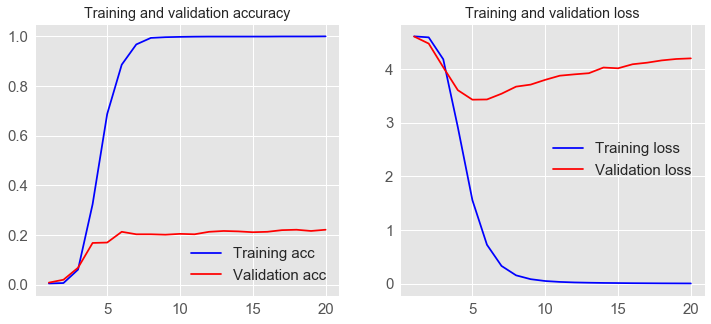

In [70]:
plot_history(history)

## MaxPooling

In [71]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(100, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['sparse_categorical_accuracy','accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 600, 50)           3124100   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_6 (Dense)              (None, 100)               1100      
Total params: 3,125,710
Trainable params: 3,125,710
Non-trainable params: 0
_________________________________________________________________


In [72]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10,
                    callbacks=[metrics])

Train on 2402 samples, validate on 601 samples
Epoch 1/20
2402/2402 [==============================] - 20s 8ms/step - loss: 4.6055 - sparse_categorical_accuracy: 0.4800 - acc: 0.0079 - val_loss: 4.5985 - val_sparse_categorical_accuracy: 0.1614 - val_acc: 0.0166
 — val_f1: 0.0000 — val_precision: 0.0000 — val_recall 0.0000
Epoch 2/20
  10/2402 [..............................] - ETA: 23s - loss: 4.5935 - sparse_categorical_accuracy: 0.1000 - acc: 0.1000

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2402/2402 [==============================] - 18s 8ms/step - loss: 4.5848 - sparse_categorical_accuracy: 0.1961 - acc: 0.0254 - val_loss: 4.5681 - val_sparse_categorical_accuracy: 0.0017 - val_acc: 0.0632
 — val_f1: 0.0000 — val_precision: 0.0000 — val_recall 0.0000
Epoch 3/20
  20/2402 [..............................] - ETA: 16s - loss: 4.5382 - sparse_categorical_accuracy: 0.0000e+00 - acc: 0.1000

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2402/2402 [==============================] - 18s 8ms/step - loss: 4.5036 - sparse_categorical_accuracy: 0.0000e+00 - acc: 0.0637 - val_loss: 4.4521 - val_sparse_categorical_accuracy: 0.0000e+00 - val_acc: 0.0649
 — val_f1: 0.0000 — val_precision: 0.0000 — val_recall 0.0000
Epoch 4/20
  20/2402 [..............................] - ETA: 18s - loss: 4.4461 - sparse_categorical_accuracy: 0.0000e+00 - acc: 0.0000e+00

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2402/2402 [==============================] - 18s 7ms/step - loss: 4.2741 - sparse_categorical_accuracy: 0.0000e+00 - acc: 0.0849 - val_loss: 4.1875 - val_sparse_categorical_accuracy: 0.0000e+00 - val_acc: 0.0832
 — val_f1: 0.0000 — val_precision: 0.0000 — val_recall 0.0000
Epoch 5/20
  20/2402 [..............................] - ETA: 17s - loss: 4.0252 - sparse_categorical_accuracy: 0.0000e+00 - acc: 0.1000

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2402/2402 [==============================] - 18s 7ms/step - loss: 3.8952 - sparse_categorical_accuracy: 0.0000e+00 - acc: 0.1274 - val_loss: 3.8585 - val_sparse_categorical_accuracy: 0.0000e+00 - val_acc: 0.1331
 — val_f1: 0.0000 — val_precision: 0.0000 — val_recall 0.0000
Epoch 6/20
  20/2402 [..............................] - ETA: 18s - loss: 3.5226 - sparse_categorical_accuracy: 0.0000e+00 - acc: 0.2000

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2402/2402 [==============================] - 18s 8ms/step - loss: 3.4900 - sparse_categorical_accuracy: 4.1632e-04 - acc: 0.1894 - val_loss: 3.5722 - val_sparse_categorical_accuracy: 0.0067 - val_acc: 0.1697
 — val_f1: 0.0033 — val_precision: 1.0000 — val_recall 0.0017
Epoch 7/20
2402/2402 [==============================] - 19s 8ms/step - loss: 3.1241 - sparse_categorical_accuracy: 0.0050 - acc: 0.2519 - val_loss: 3.3399 - val_sparse_categorical_accuracy: 0.0100 - val_acc: 0.2346
 — val_f1: 0.0033 — val_precision: 1.0000 — val_recall 0.0017
Epoch 8/20
2402/2402 [==============================] - 19s 8ms/step - loss: 2.7851 - sparse_categorical_accuracy: 0.0079 - acc: 0.3585 - val_loss: 3.1364 - val_sparse_categorical_accuracy: 0.0133 - val_acc: 0.2363
 — val_f1: 0.0099 — val_precision: 1.0000 — val_recall 0.0050
Epoch 9/20
2402/2402 [==============================] - 19s 8ms/step - loss: 2.4736 - sparse_categorical_accuracy: 0.0096 - acc: 0.4176 - val_loss: 2.9683 - val_sparse_categori

In [73]:
loss, sparse_categorical_accuracy, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, sparse_categorical_accuracy, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8518
Testing Accuracy:  0.3561


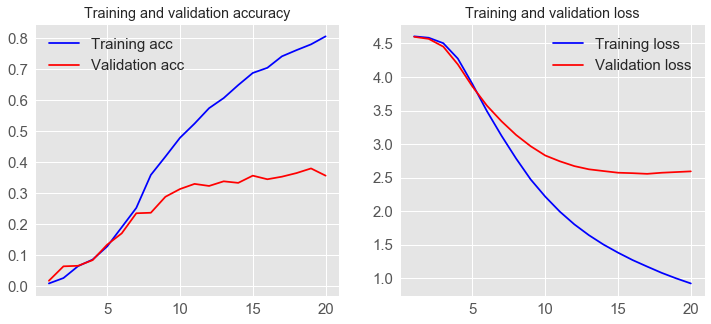

In [74]:
plot_history(history)

## Glove

Since you don’t need all words, you can focus on only the words that we have in our vocabulary. Since we have only a limited number of words in our vocabulary, we can skip most of the words in the pretrained word embeddings

In [33]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding='iso-8859-1') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [34]:
embedding_dim = 100
embedding_matrix = create_embedding_matrix(
    '../data/glove_s100.txt',
    tokenizer.word_index, embedding_dim)

In [35]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.7973303884380851

This means almost 80% of the vocabulary is covered by the pretrained model, which is a good coverage of our vocabulary.

In [47]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(100, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['sparse_categorical_accuracy','accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 600, 100)          6248100   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_6 (Dense)              (None, 100)               1100      
Total params: 6,250,210
Trainable params: 2,110
Non-trainable params: 6,248,100
_________________________________________________________________


In [48]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10,
                    callbacks=[metrics])

Train on 2402 samples, validate on 601 samples
Epoch 1/50
2402/2402 [==============================] - 1s 329us/step - loss: 4.6219 - sparse_categorical_accuracy: 0.0000e+00 - acc: 0.0075 - val_loss: 4.6051 - val_sparse_categorical_accuracy: 0.0000e+00 - val_acc: 0.0100
 — val_f1: 0.0000 — val_precision: 0.0000 — val_recall 0.0000
Epoch 2/50
 850/2402 [=========>....................] - ETA: 0s - loss: 4.6055 - sparse_categorical_accuracy: 0.0000e+00 - acc: 0.0118  

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2402/2402 [==============================] - 0s 203us/step - loss: 4.6057 - sparse_categorical_accuracy: 0.0000e+00 - acc: 0.0112 - val_loss: 4.6029 - val_sparse_categorical_accuracy: 0.0000e+00 - val_acc: 0.0133
 — val_f1: 0.0000 — val_precision: 0.0000 — val_recall 0.0000
Epoch 3/50
2402/2402 [==============================] - 0s 194us/step - loss: 4.6038 - sparse_categorical_accuracy: 0.0000e+00 - acc: 0.0112 - val_loss: 4.5980 - val_sparse_categorical_accuracy: 0.0000e+00 - val_acc: 0.0133
 — val_f1: 0.0000 — val_precision: 0.0000 — val_recall 0.0000
Epoch 4/50
2402/2402 [==============================] - 0s 185us/step - loss: 4.6006 - sparse_categorical_accuracy: 0.0000e+00 - acc: 0.0125 - val_loss: 4.5903 - val_sparse_categorical_accuracy: 0.0000e+00 - val_acc: 0.0100
 — val_f1: 0.0000 — val_precision: 0.0000 — val_recall 0.0000
Epoch 5/50
2402/2402 [==============================] - 0s 182us/step - loss: 4.5956 - sparse_categorical_accuracy: 0.0000e+00 - acc: 0.0096 - val_loss: 

In [49]:
loss, sparse_categorical_accuracy, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, sparse_categorical_accuracy, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.0558
Testing Accuracy:  0.0466


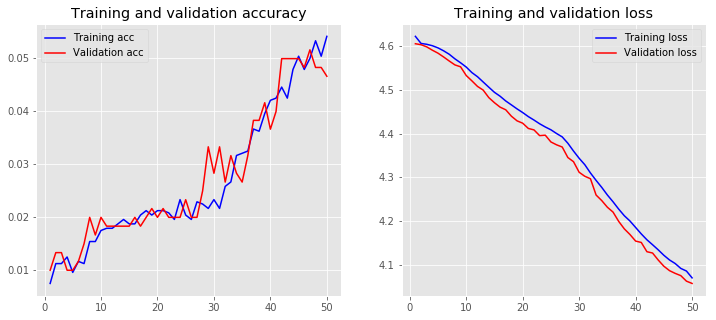

In [50]:
plot_history(history)

Since the word embeddings are not additionally trained, it is expected to be lower. But let’s now see how this performs if we allow the embedding to be trained by using trainable=True

In [51]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(100, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['sparse_categorical_accuracy','accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 600, 100)          6248100   
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_8 (Dense)              (None, 100)               1100      
Total params: 6,250,210
Trainable params: 6,250,210
Non-trainable params: 0
_________________________________________________________________


In [53]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10,
                    callbacks=[metrics])

Train on 2402 samples, validate on 601 samples
Epoch 1/20
2402/2402 [==============================] - 35s 15ms/step - loss: 4.6038 - sparse_categorical_accuracy: 0.0000e+00 - acc: 0.0108 - val_loss: 4.5967 - val_sparse_categorical_accuracy: 0.0000e+00 - val_acc: 0.0116
 — val_f1: 0.0000 — val_precision: 0.0000 — val_recall 0.0000
Epoch 2/20
  10/2402 [..............................] - ETA: 43s - loss: 4.6180 - sparse_categorical_accuracy: 0.0000e+00 - acc: 0.0000e+00

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2402/2402 [==============================] - 35s 15ms/step - loss: 4.5857 - sparse_categorical_accuracy: 0.0000e+00 - acc: 0.0133 - val_loss: 4.5798 - val_sparse_categorical_accuracy: 0.0000e+00 - val_acc: 0.0083
 — val_f1: 0.0000 — val_precision: 0.0000 — val_recall 0.0000
Epoch 3/20
2402/2402 [==============================] - 35s 15ms/step - loss: 4.5551 - sparse_categorical_accuracy: 0.0000e+00 - acc: 0.0108 - val_loss: 4.5498 - val_sparse_categorical_accuracy: 0.0000e+00 - val_acc: 0.0100
 — val_f1: 0.0000 — val_precision: 0.0000 — val_recall 0.0000
Epoch 4/20
2402/2402 [==============================] - 36s 15ms/step - loss: 4.5053 - sparse_categorical_accuracy: 0.0000e+00 - acc: 0.0162 - val_loss: 4.5021 - val_sparse_categorical_accuracy: 0.0000e+00 - val_acc: 0.0200
 — val_f1: 0.0000 — val_precision: 0.0000 — val_recall 0.0000
Epoch 5/20
2402/2402 [==============================] - 35s 15ms/step - loss: 4.4307 - sparse_categorical_accuracy: 0.0000e+00 - acc: 0.0142 - val_loss: 

In [54]:
loss, sparse_categorical_accuracy, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, sparse_categorical_accuracy, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.5229
Testing Accuracy:  0.2546


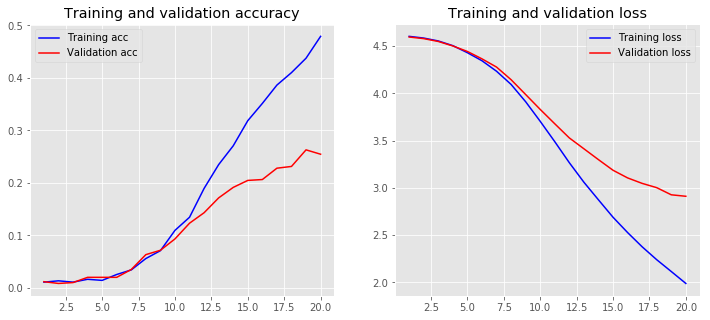

In [55]:
plot_history(history)

You can see that it is most effective to allow the embeddings to be trained. When dealing with large training sets it can boost the training process to be much faster than without. In our case it seemed to help but not by much. This does not have to be because of pretrained word embeddings.